## Accuracy helper function

In [1]:
import torch

class EasyAcc:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sumsq = 0

    def __iadd__(self, other):
        self.n += 1
        self.sum += other
        self.sumsq += other*other
        return self

    def __isub__(self, other):
        self.n += 1
        self.sum -= other
        self.sumsq += other*other
        return self

    def mean(self):
        return self.sum / max(self.n, 1)

    def var(self):
        from math import sqrt
        return sqrt(self.sumsq / max(self.n, 1) - self.mean()**2)

    def semean(self):
        from math import sqrt
        return self.var() / sqrt(max(self.n, 1))

## Inverse kinematics

In [2]:
class IK(torch.nn.Module):
    def __init__(self, dim_x, dim_a, dim_y):
        super().__init__()
        self.bilinear = torch.nn.Bilinear(in1_features=dim_x*dim_a, in2_features=dim_y, out_features=1)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    # Xs --> [batch, dim_x] 
    # As --> [batch, num_a, dim_a] 
    # Ys --> [batch, dim_y]
    def prelogits(self, Xs, As, Ys):
        batch, numa, dima = As.shape
        _, dimx = Xs.shape
        
        xview = Xs.unsqueeze(1).unsqueeze(3)            # [ batch, 1, dim_x, 1 ]
        aview = As.unsqueeze(2)                         # [ batch, num_a, 1, dim_a ]
        xaouter = torch.matmul(xview, aview)            # [ batch, num_a, dim_x, dim_a ]
        yview = Ys.unsqueeze(1).expand(-1, numa, -1)    # [ batch, num_a, dim_y ]
        return self.bilinear(xaouter.reshape(-1, numa, dimx*dima), yview.contiguous()).reshape(-1, numa)
    
    def predictions(self, prelogits):
        return self.softmax(prelogits)

In [3]:
class BilinearPredictor(torch.nn.Module):
    def __init__(self, dim_x, dim_a):
        super().__init__()
        if dim_x * dim_a > 0:
            self.bilinear = torch.nn.Bilinear(in1_features=dim_x, in2_features=dim_a, out_features=1)
        else:
            self.bilinear = None
            self.b = torch.nn.Parameter(torch.zeros(1))
        self.sigmoid = torch.nn.Sigmoid()
        
    def prelogits(self, Xs, As):
        if self.bilinear is not None:
            return self.bilinear(Xs.contiguous(), As.contiguous()).squeeze(1)
        else:
            return self.b.expand(Xs.shape[0])
    
    def prediction(self, prelogits):
        return self.sigmoid(prelogits)

## Exploration policy

In [4]:
class Policy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def sample(self, Fs):
        raise NotImplementedError
        
    def update(self, dt):
        raise NotImplementedError
        
class EpsilonGreedy(Policy):
    def __init__(self, epsilon, epsilon_t0):
        super().__init__()
        self.epsilon = epsilon
        self.epsilon_t0 = epsilon_t0
        self.t = epsilon_t0
        
    def myeps(self):
        return self.epsilon * (self.epsilon_t0 / self.t)**(1/3)
        
    def sample(self, Fs, As):
        myeps = self.myeps()
        
        unif = torch.rand(size=(Fs.shape[0], 1))
        should_explore = (unif < myeps).long()
        
        explore = torch.randint(low=0, high=Fs.shape[1], size=(Fs.shape[0], 1))
        exploit = torch.max(Fs, dim=1, keepdim=True).indices
        aindex = exploit + should_explore * (explore - exploit)
        
        action = torch.gather(input=As, dim=1, index=aindex.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
        isgreedy = (aindex == exploit).long()
        paction = myeps * torch.ones(size=(Fs.shape[0],1))/Fs.shape[1] + isgreedy * (1 - myeps)
        
        return action, paction, aindex
    
    def update(self, dt):
        self.t += dt

## Set up simulator

In [5]:
class Simulator(torch.utils.data.Dataset):
    def __init__(self, *, T, nusers, nactions, pdislike, seed):
        import random

        assert nusers > 1
        assert nactions > 2
        
        super().__init__()

        self.random = random.Random(seed)
        self.nusers = nusers
        self.nactions = nactions
        self.actions = torch.eye(self.nactions)
        self.feedbacks = [ 'click', 'like', 'dislike', 'skip', 'none']
        self.pdislike = pdislike

        # User's ground truth preference
        # This is only used to evaluate IGL learning result
        # Never revealed to IGL algorithm
        self.enjoys = {}
        self.hates = {}
        
        for n in range(nusers):            
            enjoy_action, hate_action = self.random.sample(list(range(nactions)), 2)
            self.enjoys[n] = enjoy_action
            self.hates[n] = hate_action
        
        self.contexts = torch.Tensor([ self.random.randint(0, self.nusers-1) for _ in range(T) ]).long()
        self.random = random.Random(1664525*seed + 1013904223)

    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        context = torch.nn.functional.one_hot(self.contexts[idx], num_classes=self.nusers).float()
        return context, self.actions

    def first_nonzero(self, x, axis=0):
        nonz = (x != 0)
        return ((nonz.cumsum(axis) == 1) & nonz).max(axis, keepdim=True)
    
    def get_one_hot_id(self, onehot):
        return self.first_nonzero(onehot, axis=-1)[1].squeeze().item()
        
    def enjoys_the_action(self, Xs, As):
        user_id = self.get_one_hot_id(Xs)
        action_id = self.get_one_hot_id(As)
        return self.enjoys[user_id] == action_id
    
    def hates_the_action(self, Xs, As):
        user_id = self.get_one_hot_id(Xs)
        action_id = self.get_one_hot_id(As)
        return self.hates[user_id] == action_id

## 3 states simulator

In [6]:
class ThreeStatesSimulator(Simulator):
    def sample_feedback(self, Xs, As):
        results = []
        for context, chosen_action in zip(Xs, As):
            if self.enjoys_the_action(context, chosen_action):
                probs = [ 0.75, 0.25, 0, 0, 0 ]
            elif self.hates_the_action(context, chosen_action):
                probs = [ 0, 0, self.pdislike, 1 - self.pdislike, 0 ]
            else:
                probs = [ 0, 0, 0, 0, 1 ]
        
            feedback = self.random.choices(list(range(len(self.feedbacks))), weights=probs)[0]
            results.append(torch.nn.functional.one_hot(torch.LongTensor([feedback]), num_classes = len(self.feedbacks)).float())
        return torch.cat(results, dim=0)
    
    def is_definitely_negative(self, Xs, Ys):
        return self.first_nonzero(Ys, axis=-1)[1].squeeze(1) == 2
    
    def true_reward(self, Xs, As):
        return [ self.enjoys_the_action(x, a) - self.hates_the_action(x, a) for x, a in zip(Xs, As) ]

## Epsilon-Greedy

In [7]:
def run_sim(*, seed, T=150_000, batch_size=100, pdislike=0.1, n_states=2):
    from math import sqrt
    import itertools
    
    def binent(p):
        from math import log
        return -p * log(p) - (1 - p) * log(1 - p) 

    nusers = 5
    nactions = 11
    lr = 0.001
    epsilon = 1
    epsilon_t0 = 100
    
    # n_states - 1 -> the number of latent states we are certain with
    n_extreme_states = n_states - 1
    optimal_accuracy = ((nactions - n_extreme_states) / nactions) * (1 / (nactions - n_extreme_states)) + ((1/nactions) * 1) * n_extreme_states
    print(f'optimal action prediction accuracy = {optimal_accuracy : .4f}')
    print(f'optimal neg log loss = {(1/2 * binent(pdislike)):.4f}')
    print(f'optimal const log loss = {binent(pdislike / 2):.4f}')

    true_rewards = []

    sim = ThreeStatesSimulator(T=T, nusers=nusers, nactions=nactions, pdislike=pdislike, seed=seed); seed += 1
        
    torch.manual_seed(seed); seed += 1
    loader = torch.utils.data.DataLoader(sim, batch_size=batch_size, shuffle=False)

    policy = EpsilonGreedy(epsilon, epsilon_t0)

    ik = IK(dim_x=nusers, dim_a=nactions, dim_y=len(sim.feedbacks))
    negpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)
    constpredictor = BilinearPredictor(dim_x=0, dim_a=0)
    rewardpredictor = BilinearPredictor(dim_x=nusers, dim_a=nactions)

    actionloss = torch.nn.CrossEntropyLoss(reduction='none')
    actionoptimizer = torch.optim.Adam(ik.parameters(), lr=lr*sqrt(batch_size))
    negloss = torch.nn.BCEWithLogitsLoss(reduction='none')
    negoptimizer = torch.optim.Adam(itertools.chain(negpredictor.parameters(), constpredictor.parameters()), lr=lr*sqrt(batch_size))
    regloss = torch.nn.MSELoss(reduction='none')
    regoptimizer = torch.optim.Adam(rewardpredictor.parameters(), lr=lr*sqrt(batch_size))

    print('{:<5s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s} {:<8s}\t{:<8s}'.format(
        'bno',  'loss', 'since', 'acc', 'since', 'neg', 'since', 'const', 'since', 'reg', 'since', 'pol', 'since', 'greedy', 'since', 'eps'), flush=True) 
    avloss, avacc, avnegloss, avconstloss, avregloss, avpol, avgreedy = [ EasyAcc() for _ in range(7) ]
    avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]
    
    for bno, minibatch in enumerate(loader):
        Xs, As = minibatch

        with torch.no_grad():
            rhat = rewardpredictor.prelogits(Xs.unsqueeze(1).expand(-1, As.shape[1], -1), As).squeeze(2)
            action, paction, aindex = policy.sample(rhat, As)
            
            truerewards = torch.Tensor(sim.true_reward(Xs, action))
            avpol += torch.mean(truerewards).item()
            avpolsincelast += torch.mean(truerewards).item()
            
            true_rewards.append(torch.mean(truerewards).item())

            greedy = torch.max(rhat, dim=1, keepdim=True).indices
            greedyaction = torch.gather(input=As, dim=1, index=greedy.unsqueeze(2).expand(-1, -1, As.shape[2])).squeeze(1)
            greedyrewards = torch.Tensor(sim.true_reward(Xs, greedyaction))
            avgreedy += torch.mean(greedyrewards).item()
            avgreedysincelast += torch.mean(greedyrewards).item()

            Ys = sim.sample_feedback(Xs, action)
            
        actionoptimizer.zero_grad()
        prepapred = ik.prelogits(Xs, As, Ys)
        
        rawactionloss = actionloss(prepapred, aindex.squeeze(1)).unsqueeze(1)
        actioniw = 1/(As.shape[1]*paction)
        batchactionloss = torch.sum(torch.mul(actioniw, rawactionloss)) / torch.sum(actioniw)
        batchactionloss.backward() #learn
        actionoptimizer.step()
                
        with torch.no_grad():
            papred = torch.gather(input=ik.predictions(prepapred), index=aindex, dim=1).squeeze()
            isExtreme = papred > (2 / As.shape[1])
            
        if torch.any(isExtreme):
            extremeXs = torch.atleast_2d(Xs[isExtreme])
            extremeAs = torch.atleast_2d(action[isExtreme])
            extremeYs = torch.atleast_2d(Ys[isExtreme])
            extremepaction = torch.atleast_2d(paction[isExtreme])
            with torch.no_grad():
                isNeg = sim.is_definitely_negative(extremeXs, extremeYs).float()
                
            negoptimizer.zero_grad()
            negpred = negpredictor.prelogits(extremeXs, extremeAs)
            constpred = constpredictor.prelogits(torch.empty(extremeXs.shape[0], 0), None)
            extremeactioniw = 1/(As.shape[1]*extremepaction)
            batchnegloss = torch.sum(torch.mul(extremeactioniw, negloss(negpred, isNeg).unsqueeze(1))) / torch.sum(extremeactioniw)
            batchconstloss = torch.sum(torch.mul(extremeactioniw, negloss(constpred, isNeg).unsqueeze(1))) / torch.sum(extremeactioniw)
            (batchnegloss + batchconstloss).backward()
            negoptimizer.step()
            
            with torch.no_grad():
                fakereward = torch.zeros(Xs.shape[0])
                fakereward[isExtreme] = 1 - 2 * (negpred > constpred).float()

                states, counts = fakereward.unique(return_counts=True)
                
            regoptimizer.zero_grad()
            rewardpred = rewardpredictor.prelogits(Xs, action)
            batchregloss = torch.sum(torch.mul(actioniw, regloss(rewardpred, fakereward).unsqueeze(1))) / torch.sum(actioniw)
            batchregloss.backward()
            regoptimizer.step()
            
            with torch.no_grad():
                policy.update(Xs.shape[0])
        else:
            batchnegloss = None

        with torch.no_grad():
            avloss += batchactionloss.item()
            avlosssincelast += batchactionloss.item()
            if batchnegloss is not None:
                avnegloss += batchnegloss.item()
                avneglosssincelast += batchnegloss.item()
                avconstloss += batchconstloss.item()
                avconstlosssincelast += batchconstloss.item()
                avregloss += batchregloss.item()
                avreglosssincelast += batchregloss.item()
                
            amaxpred = torch.max(prepapred, dim=1, keepdim=True)
            avacc += torch.mean(torch.mul(actioniw, (aindex == amaxpred.indices).float())).item()
            avaccsincelast += torch.mean(torch.mul(actioniw, (aindex == amaxpred.indices).float())).item()

            if bno & (bno - 1) == 0:
                print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
                    bno,  
                    avloss.mean(), avlosssincelast.mean(),
                    avacc.mean(), avaccsincelast.mean(),
                    avnegloss.mean(), avneglosssincelast.mean(),
                    avconstloss.mean(), avconstlosssincelast.mean(),
                    avregloss.mean(), avreglosssincelast.mean(),
                    avpol.mean(), avpolsincelast.mean(),
                    avgreedy.mean(), avgreedysincelast.mean(),
                    policy.myeps(),
                ), flush=True)
                avlosssincelast, avaccsincelast, avneglosssincelast, avconstlosssincelast, avreglosssincelast, avpolsincelast, avgreedysincelast = [ EasyAcc() for _ in range(7) ]

    print('{:<5d}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f} {:<8.5f}\t{:<8.5f}'.format( 
        bno,  
        avloss.mean(), avlosssincelast.mean(),
        avacc.mean(), avaccsincelast.mean(),
        avnegloss.mean(), avneglosssincelast.mean(),
        avconstloss.mean(), avconstlosssincelast.mean(),
        avregloss.mean(), avreglosssincelast.mean(),
        avpol.mean(), avpolsincelast.mean(),
        avgreedy.mean(), avgreedysincelast.mean(),
        policy.myeps()
    ), flush=True)
    return true_rewards


## Plot helper function

In [8]:
def plot_result(true_rewards):
    from matplotlib import pyplot as plt
    from matplotlib import rc
    import pandas as pd

    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    
    legend_font_size = 14
    tick_font_size = 14
    label_font_size = 16
    xlim = 1450
    ylim = 1

    color_1 = (51/255,34/255,136/255)
    color_2 = (17/255,119/255,51/255)
    color_4 = (221/255,204/255,119/255)
    color_8 = (170/255,68/255,153/255)


    plt.figure(figsize=(6, 2.5))
    plt.plot(pd.Series(true_rewards[3]).rolling(5).mean(),color=color_8,label='$p=0.8$')
    plt.plot(pd.Series(true_rewards[2]).rolling(5).mean(),color=color_4,label='$p=0.4$')
    plt.plot(pd.Series(true_rewards[1]).rolling(5).mean(),color=color_2,label='$p=0.2$')
    plt.plot(pd.Series(true_rewards[0]).rolling(5).mean(),color=color_1,label='$p=0.1$')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legend_font_size)
    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
    plt.xlabel('number of iterations', fontsize=label_font_size)
    plt.ylabel('average reward', fontsize=label_font_size)
    plt.xlim(0, xlim)
    plt.ylim(-0.1, ylim)

# Run simulation

## Compare different pdislikes

In [9]:
import numpy as np
import pandas as pd

import math

def compare_pdislikes(*, seeds, pdislikes, T=150_000, batch_size=100):
    true_all = []
    t = math.floor(T/batch_size)

    for pdislike in pdislikes:
        true_r_tmp = []
        for seed in seeds:
            true_r = run_sim(seed=seed, T=T, batch_size=batch_size, pdislike=pdislike, n_states=3)
            true_r_tmp.append(true_r)
        true_all.append([])

        for j in range(t):
            tmp = []
            for i in range(len(true_r_tmp)):
                tmp.append(true_r_tmp[i][j])
            true_all[-1].append(np.mean(tmp))
    plot_result(true_all)

optimal action prediction accuracy =  0.2727
optimal neg log loss = 0.1625
optimal const log loss = 0.1985
bno  	loss     since   	acc      since   	neg      since   	const    since   	reg      since   	pol      since   	greedy   since   	eps     
0    	2.39571  2.39571 	0.04000  0.04000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.03000  0.03000 	0.24000  0.24000 	1.00000 
1    	2.39561  2.39552 	0.04500  0.05000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.03000  0.03000 	0.21500  0.19000 	1.00000 
2    	2.39310  2.38809 	0.06667  0.11000 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.02333  0.01000 	0.19333  0.15000 	1.00000 
4    	2.39356  2.39423 	0.09400  0.13500 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.02000  0.01500 	0.18000  0.16000 	1.00000 
8    	2.38582  2.37614 	0.13556  0.18750 	0.00000  0.00000 	0.00000  0.00000 	0.00000  0.00000 	0.01333  0.00500 	0.18889  0.20000 	1.00000 
16   	2.36761  2.34713 	0.19000  0.25125 	0.000

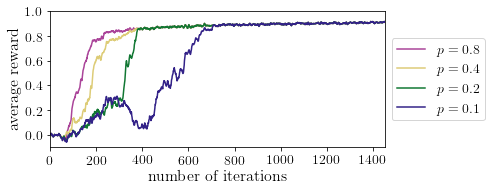

In [10]:
compare_pdislikes(
    seeds=[1, 13, 19, 23, 29, 31, 37, 39, 41, 43],
    pdislikes = [0.1, 0.2, 0.4, 0.8]
)
